In [1]:
from collections import defaultdict, Counter

from workflow.config import PCT_VALUES
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.gunc.aggregate_max_css_level_merged import AggregateMaxCssLevelMerged
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from workflow.external.gtdb_metadata import GtdbMetadataR207

In [2]:
DF_META = GtdbMetadataR207().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,gtdb_type_species_of_genus,ncbi_taxonomy,ncbi_taxonomy_unfiltered,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,d__Bacteria;x__Terrabacteria group;p__Firmicut...,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,t,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,t,d__Archaea;p__Nanoarchaeota;c__;o__Nanoarchaea...,d__Archaea;x__DPANN group;p__Nanoarchaeota;o__...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


In [3]:
DF = RemoveGuncFailedContigsByContaminationSpCluster().output().read_cached()
print(DF.shape)

UNQ_GIDS = set(DF.index.get_level_values(0))

print(f'{len(UNQ_GIDS):,} failed gids')
DF.head()

(578539, 5)
35,723 failed gids


new_sp_rep      ani        af    type  same
gid             pct                                                  
GCA_000143435.1 1    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                5    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                15   GCF_001435955.1  97.6349  0.829228  sp_rep  True
GCA_000153745.1 5                NaN      NaN       NaN  no_ani  True
GCA_000155005.1 1    GCF_003697165.2  96.5203  0.827668  sp_rep  True

226
Counter({'high': 132, 'medium': 94})
None


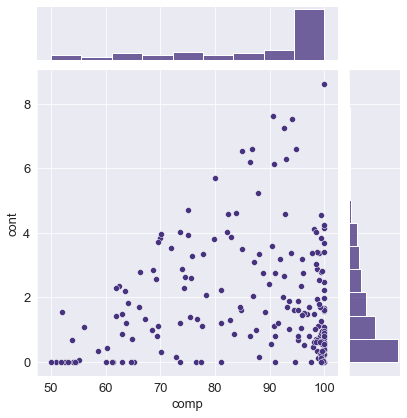

In [54]:
def gen_data2():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed.reset_index()
    df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]

    unq_gids =  set(df_changed['gid'].unique())

    print(len(unq_gids))

    rows = list()

    for gid in unq_gids:
        comp = DF_META.loc[gid, 'checkm_completeness']
        cont = DF_META.loc[gid, 'checkm_contamination']

        if comp >=90 and cont <= 5:
            quality = 'high'
        elif comp >= 50 and cont <= 10:
            quality = 'medium'
        else:
            quality = 'low'

        rows.append({
            'gid': gid,
            'comp': comp,
            'cont': cont,
            'type': quality,
        })

    df = pd.DataFrame(rows)


    plt.rcParams['svg.fonttype'] = 'none'

    plt.rcParams.update({'font.size': 13})
    sns.jointplot(data=df, x='comp', y='cont')

    plt.savefig('/tmp/checkm.svg')

    print(Counter([x for x in df['type']]))


data = gen_data2()

print(data)

In [4]:
def gen_data():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed.reset_index()
    df_changed = df_changed[df_changed['pct'].isin(PCT_VALUES)]

    d_pct_to_changes = defaultdict(list)

    for cur_pct in PCT_VALUES:
        df_subset = df_changed[df_changed['pct'] == cur_pct]
        df_subset = df_subset.sort_values(by=['gid', 'pct'], ascending=[True, False])

        for _, row in df_subset.iterrows():
            gid = row['gid']

            meta_row = DF_META.loc[gid]
            is_rep = meta_row['gtdb_representative'] == 't'

            if is_rep:
                change_type = 'rep_changed'
            else:
                if row['type'] == 'no_af' or row['type'] == 'no_ani':
                    change_type = 'novel_sp'
                else:
                    change_type = 'sp_changed'

            d_pct_to_changes[cur_pct].append((change_type, gid))

    return d_pct_to_changes

data = gen_data()

print(data)

defaultdict(<class 'list'>, {1: [('rep_changed', 'GCA_000761495.1'), ('rep_changed', 'GCA_007713455.1'), ('rep_changed', 'GCA_018363915.1'), ('rep_changed', 'GCA_900548495.1'), ('rep_changed', 'GCA_900555225.1'), ('rep_changed', 'GCA_900757715.1'), ('rep_changed', 'GCA_900759445.1'), ('rep_changed', 'GCF_000438455.1'), ('rep_changed', 'GCF_000935215.1'), ('rep_changed', 'GCF_001544135.1'), ('rep_changed', 'GCF_001571065.1'), ('rep_changed', 'GCF_002156525.1'), ('rep_changed', 'GCF_002216875.1'), ('rep_changed', 'GCF_002989035.1'), ('rep_changed', 'GCF_003064105.1'), ('rep_changed', 'GCF_003935375.1'), ('rep_changed', 'GCF_011045835.1'), ('rep_changed', 'GCF_014764705.1'), ('rep_changed', 'GCF_016860525.1')], 5: [('rep_changed', 'GCA_000761495.1'), ('rep_changed', 'GCA_002712565.1'), ('rep_changed', 'GCA_002720285.1'), ('rep_changed', 'GCA_003086435.1'), ('rep_changed', 'GCA_007713455.1'), ('rep_changed', 'GCA_016780245.1'), ('rep_changed', 'GCA_018363915.1'), ('rep_changed', 'GCA_90054

406
297
0
703
   CheckM completeness %  CheckM contamination %  \
0                  99.93                    0.41   
1                 100.00                    0.22   
2                  99.39                    0.91   
3                  93.55                    1.88   
4                  75.56                    2.59   

                        species              gid  pct         type  
0  s__Acinetobacter idrijaensis  GCA_000761495.1    1  rep_changed  
1  s__Pseudomonas_A sp007713455  GCA_007713455.1    1  rep_changed  
2   s__Anaerococcus vaginalis_C  GCA_018363915.1    1  rep_changed  
3    s__Collinsella sp900548495  GCA_900548495.1    1  rep_changed  
4    s__Collinsella sp900555225  GCA_900555225.1    1  rep_changed  


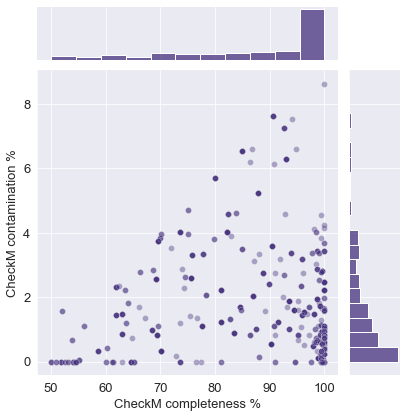

In [42]:
def rgb_to_hex(rgb):
    rgb = tuple([int(x * 255) for x in rgb])
    return '#' + '%02x%02x%02x' % rgb
def make_plot():

    comp = 'CheckM completeness %'
    cont = 'CheckM contamination %'

    cmap = sns.color_palette("viridis", 8)
    colours = [rgb_to_hex(x) for x in cmap]

    rows = list()

    n_high = 0
    n_med = 0
    n_low = 0

    for pct, lst_changes in data.items():
        for change_type, gid in lst_changes:
            meta_row = DF_META.loc[gid]
            complete = meta_row['checkm_completeness']
            contam = meta_row['checkm_contamination']
            species = meta_row['species']

            if complete >=90 and contam <= 5:
                n_high += 1
            elif complete >= 50 and contam <= 10:
                n_med += 1
            else:
                n_low += 1

            rows.append(
                {comp: complete,
                 cont: contam,
                 'species': species,
                 'gid': gid,
                 'pct': pct,
                 'type': change_type
                 }
            )
    df = pd.DataFrame(rows)

    plt.rcParams['svg.fonttype'] = 'none'

    plt.rcParams.update({'font.size': 13})
    sns.jointplot(data=df, x=comp, y=cont, alpha=0.4)
    plt.savefig('/tmp/checkm.svg')

    total_n = n_high + n_med + n_low

    print(n_high)
    print(n_med)
    print(n_low)
    print(total_n)



    # sns.jointplot(data=df, x=comp, y=cont, hue='pct',palette={
    #                   1: colours[0],
    #     5: colours[1],
    #     10: colours[2],
    #     15: colours[3],
    #     20: colours[4],
    #     30: colours[5],
    #     40: colours[6],
    #     50: colours[7]
    #               })

    print(df.head())
    return

make_plot()